In [85]:
import numpy as np
from queue import PriorityQueue
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# matrice de similarité
sim_mat = np.array([[10, 6, 0, 0, 0, 0, 0, 0, 0],
                    [6, 10, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 10, 5, 3, 3, 1, 1, 0],
                    [0, 0, 5, 10, 1, 2, 1, 1, 0],
                    [0, 0, 3, 1, 10, 4, 1, 2, 0],
                    [0, 0, 3, 2, 4, 10, 1, 4, 0],
                    [0, 0, 1, 1, 1, 1, 10, 1, 0],
                    [0, 0, 1, 1, 2, 4, 1, 10, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 10]])


In [86]:
#                                                   #
#           Fonction d'affichage faite par          #
#                   Romain Bossy                    #
#                                                   #

N = len(sim_mat)

# Dessine la fusion de deux ensemble
def fusion(oxa, oxb, s, c, oya=10, oyb=10):
    xa = [oxa, oxa]
    xb = [oxb, oxb]

    ya = [oya, s]
    yb = [oyb, s]

    xl = [oxa, oxb]
    yl = [s, s]

    plt.plot(xa, ya, color=c)
    plt.plot(xb, yb, color=c)
    plt.plot(xl, yl, color=c)


# Dessine le dendogramme à partir de sa liste des fusions
def affichage_dendrogramme(dendrogramme):
    nums = [i for i in range(N)]
    ens = []
    sims = []
    operations = []

    # Constructions de la liste des opérations de dessin que à faire
    for f in dendrogramme:
        if f[0] in nums and f[1] in nums:
            ens.append(f.copy())
            sims.append(sim_mat[f[0], f[1]])
            operations.append(("Ajout ensemble", f.copy()))
        elif f[1] in nums and not f[0] in nums:
            i = 0
            while not f[0] in ens[i]:
                i += 1
    
            nouvelle_sim = min(sims[i] - 0.25, sim_mat[f[0], f[1]])
            operations.append(("Ajout élément", ens[i].copy(), f[1], sims[i], nouvelle_sim))
            sims[i] = nouvelle_sim
            ens[i].append(f[1])
        elif f[0] in nums and not f[1] in nums:
            i = 0
            while not f[1] in ens[i]:
                i += 1
    
            nouvelle_sim = min(sims[i] - 0.25, sim_mat[f[0], f[1]])
            operations.append(("Ajout élément", ens[i].copy(), f[0], sims[i], nouvelle_sim))
            sims[i] = nouvelle_sim
            ens[i].append(f[0])
        else:
            i = 0
            while not f[0] in ens[i]:
                i += 1
    
            j = 0
            while not f[1] in ens[j]:
                j += 1
            
            nouvelle_sim = min(sims[i], sims[j]) - 1
            gauche = (max(ens[i]) + min(ens[i])) / 2
            droite = (max(ens[j]) + min(ens[j])) / 2
            operations.append(("Fusion", ens[i].copy(), ens[j].copy(), sims[i], sims[j], nouvelle_sim, gauche, droite))
            sims[i] = nouvelle_sim
            ens[i].extend(ens[j])
            ens.pop(j)
            sims.pop(j)
            
        if f[0] in nums:
            nums.remove(f[0])
        if f[1] in nums:
            nums.remove(f[1])
    
    positions_x = {}
    for i in range(len(ens[0])):
        positions_x[ens[0][i]] = i 

    # Dessin du dendogramme à partir des opérations de dessin déterminées plus tôt
    for op in operations:
        type = op[0]
        if type == "Ajout ensemble":
            e = op[1]
            fusion(positions_x[e[0]], positions_x[e[1]], sim_mat[e[0], e[1]], 'red') # La couleur rouge signifie que deux classes ont été fusionnés
        elif type == "Ajout élément":
            pos = []
            for i in range(len(op[1])):
                pos.append(positions_x[op[1][i]])
            
            a = sum(pos) / float(len(pos))
            b = op[2]
            fusion(a, positions_x[b], op[4], 'blue', oya=op[3]) # La couleur bleu signifie que la classe a été ajouté à un ensemble
        elif type == "Fusion":
            pos = []
            for i in range(len(op[1])):
                pos.append(positions_x[op[1][i]])
            a = sum(pos) / float(len(pos))

            pos = []
            for i in range(len(op[2])):
                pos.append(positions_x[op[2][i]])
            b = sum(pos) / float(len(pos))
            
            fusion(a, b, op[5], 'green', oya=op[3], oyb=op[4]) # La couleur verte signifie que deux ensembles ont été fusionnés

    # Les labels des classes
    labels = []
    for i in positions_x.keys():
        labels.insert(positions_x[i], str(i))
    
    plt.xticks(list(positions_x.values()), labels)
        
    # On supprime l'axe des y et on l'inverse
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().invert_yaxis()
    plt.xlabel("Classes")
    plt.show()

# Première implémentation de l'algorithme de clustering hiérarchique agglomératif

In [87]:
# génération du tableau de file de priorité sans les valeurs de la diagonale
def generate_priority_queue(sim_mat): # O(N²)
    N = sim_mat.shape[0]
    P = []
    for i in range(N):
        P.append(PriorityQueue())
    for i in range(N):
        for j in range(N):
            if i != j:
                P[i].put((-sim_mat[i][j], j)) # on met les valeurs de la matrice de similarité dans la file de priorité en négatif pour avoir une file de priorité qui trie les valeurs par ordre croissant (spécificité de la file de priorité de PriorityQueue)
    return P

# implémentation de l'algorithme de clustering hiérarchique agglomératif
def clustering_hierarchique_agglomeratif(sim_mat): # O(N log³(N)) on considère que le tri de la file de priorité est en O(log(N)) et que la file de priorité n'a que les éléments actifs
    # Taille de la matrice de similarité
    N = sim_mat.shape[0]

    # initialisation de la liste des classes actives
    I = [1 for _ in range(N)]

    # initialisation du dendrogramme comme un ndarray de taille N-1
    dendrogramme = [[0, 0] for _ in range(N - 1)]

    # initialisation du tableau de file de priorité
    P = generate_priority_queue(sim_mat)
    temp_queue = PriorityQueue()
    
    # pour chaque itération k ∈ {1, ..., N − 1} faire
    for k in range(N - 1): # O(N-1)
        # a = argmax P[i].MAX.sim ; avec i ∈ {1, . . . , N} et I[i] = 1 ;
        a = 0
        max_sim = 1
        for i in range(N):  # on cherche la classe i la plus proche de la classe a complexité O(N log(N)) car on considère que les elements actifs 
            if I[i] == 1 and P[i].queue[0][0] < max_sim:  # si la classe i est active et si la classe i est plus proche de la classe a que la classe a ne l'est d'elle-même
                max_sim = P[i].queue[0][0]
                a = i
        # b = P[a].MAX.index ;
        b = P[a].queue[0][1]
        
        dendrogramme[k][0] = a
        dendrogramme[k][1] = b
        
        # I[b] = 0 ;
        I[b] = 0

        # supprimer S[a][b] de P[a] ;
        P[a].get()

        for i in range(N):          # O(log(N))) car le il y a un if qui itère sur un élément en moins à chaque fois.
            if I[i] == 1 and i != a:
                # supprimer S[i][a] de P[i] ;
                for j in range(P[i].qsize()): # O(log(N)) car la file de priorité n'a que les éléments actifs
                    if P[i].queue[0][1] != a and P[i].queue[0][1] != b:
                        temp_queue.put(P[i].queue[0])
                    P[i].get()
                # remettre les valeurs dans la file de priorité
                for j in range(temp_queue.qsize()): # O(log(N)) car la file de priorité n'a que les éléments actifs
                    P[i].put(temp_queue.queue[0])
                    temp_queue.get()

                # supprimer S[a][i] de P[a] ;
                for j in range(P[a].qsize()): # O(log(N)) car la file de priorité n'a que les éléments actifs
                    if P[a].queue[0][1] != i:
                        temp_queue.put(P[a].queue[0])
                    P[a].get()
                # remettre les valeurs dans la file de priorité
                for j in range(temp_queue.qsize()): # O(log(N)) car la file de priorité n'a que les éléments actifs
                    P[a].put(temp_queue.queue[0])
                    temp_queue.get()

                # S[i][a] ← max{S[i][a], S[i][b]} ; # Méthode du lien unique
                sia = max(sim_mat[i][a], sim_mat[i][b])

                # insérer (avec tri) S[i][a] dans P[i] et S[a][i] dans P[a] ;
                P[i].put((-sia, a))
                P[a].put((-sia, i))
    print(dendrogramme)
    affichage_dendrogramme(dendrogramme)
    return dendrogramme

[[0, 1], [2, 3], [4, 5], [4, 7], [2, 4], [2, 6], [0, 2], [0, 8]]


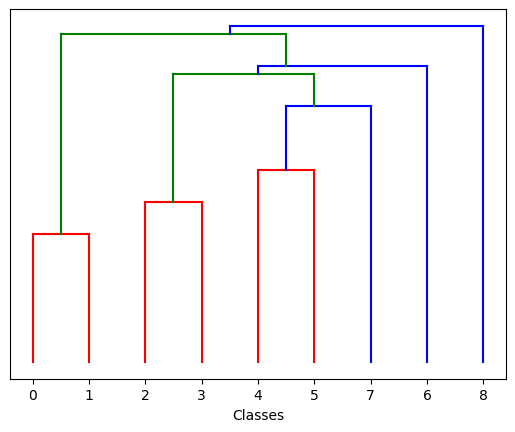

In [88]:
# test de l'algorithme de clustering hiérarchique agglomératif
dendrogramme1 = clustering_hierarchique_agglomeratif(sim_mat)

# Deuxième implémentation de l'algorithme de clustering hiérarchique agglomératif

In [89]:
# on degage les valeur de la diagonale
def suppr_diagonale (sim_mat): # O(N²)
    N = sim_mat.shape[0]
    P = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i != j:
                P[i][j] = sim_mat[i][j]
    return P

# fonction qui retourne un tableau de la forme [P[i].sim, P[i].index]
def tab_des_max_val(sim_mat): # O(N)
    N = sim_mat.shape[0]
    tab = []
    for i in range(N):
        tab.append([max(sim_mat[i]), sim_mat[i].argmax()])
    return tab

def clustering_hierarchique_agglomeratif2(sim_mat): # O(N²)
    P = suppr_diagonale(sim_mat) # fonction qui supprime la diagonale de la matrice de similarité
    P = tab_des_max_val(P) # fonction qui retourne un tableau de la forme P = [P[i].sim, P[i].index]
    
    I = [i for i in range(N)]
    dendrogramme = [[0, 0] for _ in range(N - 1)]
    
    for k in range(N - 1): # O(N-1)
        a = 0
        maxi = 0
        # a = argmax de P[i][0] quand i:I[i]=i
        for i in range(N): # O(log(N))
            if I[i] == i and P[i][0] > maxi:
                maxi = P[i][0]
                a = i
        b = I[P[a][1]]
        P[a][0] = -1
        dendrogramme[k][0] = a
        dendrogramme[k][1] = b
        for i in range(N): # O(N) car on ne scinde pas la boucle en deux comme dans la fonction précédente
            if I[i] == i and i != a and i != b:
                sim_mat[i][a] = max(sim_mat[i][a], sim_mat[i][b])
                sim_mat[a][i] = max(sim_mat[i][a], sim_mat[i][b])
            if I[i] == b:
                I[i] = a
            if I[i] == i and i != a and sim_mat[a][i] > P[a][0]:
                P[a][0] = sim_mat[a][i]
                P[a][1] = i
    print(dendrogramme)
    affichage_dendrogramme(dendrogramme)
    return dendrogramme

[[0, 1], [2, 3], [4, 5], [4, 7], [2, 4], [2, 6], [0, 2], [0, 8]]


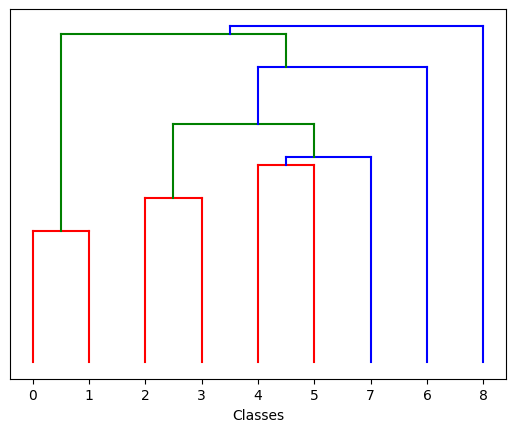

In [90]:
dendrogramme2 = clustering_hierarchique_agglomeratif2(sim_mat)

# Comparaison des deux implémentations

In [91]:
def compare_dendrogramme(dendrogramme1, dendrogramme2): # Verification que les deux dendrogrammes sont identiques
    N = len(dendrogramme1)
    for i in range(N):
        if dendrogramme1[i][0] != dendrogramme2[i][0] or dendrogramme1[i][1] != dendrogramme2[i][1]:
            return False
    return True

print(compare_dendrogramme(dendrogramme1, dendrogramme2))

True


# Remarque :
### Beaucoup d'optimisation peuvent etre ajouter au code pour empécher d'avoir à faire N fois la verification de la condition I[i] == 1. On sait simplement que l'on a un nombre de classes actives qui diminue à chaque itération. On peut donc stocker le nombre de classes actives dans une variable et un tableau des indexs des classes activent. On supprime l'index de la classe qui a été fusionné et on décrémente le nombre de classes actives.
### On remarque que les deux dendrogrammes sont identiques, ce qui signifie que notre implémentation de l'algorithme de clustering hiérarchique agglomératif est correcte.

# Comparaison avec la fonction de scipy

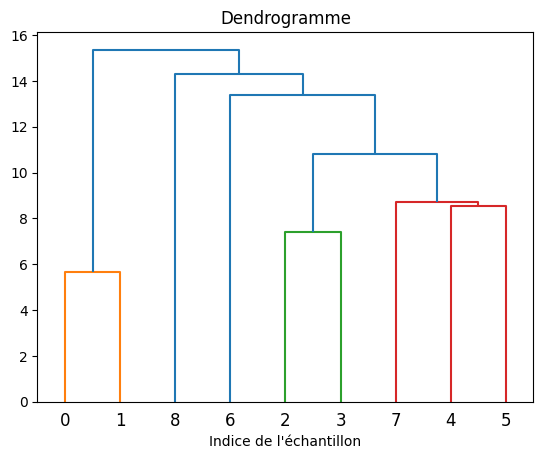

In [92]:
# maintenant, on va utiliser la fonction de scipy pour comparer les résultats
linkage_matrix = linkage(sim_mat, 'single') # Elle est composé de N-1 lignes et 4 colonnes (i, j, d, n) avec i et j les indices des clusters fusionnés, d la distance entre les clusters et n le nombre d'éléments dans le cluster
dendrogram(linkage_matrix, orientation='top')
plt.title('Dendrogramme')
plt.xlabel('Indice de l\'échantillon')
plt.show()

# Remarque :
### On remarque que le dendrogramme de la fonction de scipy est identique à notre implémentation de l'algorithme de clustering hiérarchique agglomératif.

# Conclusion sur la complexité des deux algorithmes :
### Notre implémentation de l'algorithme de clustering hiérarchique agglomératif, le premier est en O(N*log³(N)) et le deuxième est en O(N²). On remarque que le premier est plus rapide que le deuxième.